<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 36.0MB/s]


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

In [7]:
np.unique(df_reviews['Rating'])

array([0, 1, 2, 3, 4])

In [8]:
df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

Los ratings 4 y 5 representan el 76% del dataset. Se puede notar cómo las reviews van disminuyendo conforme son más negativas. Es decir, hay muy pocas de 1 estrella y muchas de 5 estrellas.

In [9]:
min_val = int(min(df_reviews['Rating'].value_counts()) * 1.10)

In [10]:
idx_4 = df_reviews.loc[df_reviews['Rating'] == 4].reset_index(drop = True)[:min_val]
idx_3 = df_reviews.loc[df_reviews['Rating'] == 3].reset_index(drop = True)[:min_val]
idx_2 = df_reviews.loc[df_reviews['Rating'] == 2].reset_index(drop = True)[:min_val]
idx_1 = df_reviews.loc[df_reviews['Rating'] == 1].reset_index(drop = True)[:min_val]
idx_0 = df_reviews.loc[df_reviews['Rating'] == 0].reset_index(drop = True)[:min_val]

In [11]:
df_reviews = pd.DataFrame(np.vstack((idx_4, idx_3, idx_2, idx_1, idx_0)), columns = df_reviews.columns)

In [12]:
# Ahora el dataset está balanceado
df_reviews['Rating'].value_counts()

4    903
3    903
2    903
1    903
0    821
Name: Rating, dtype: int64

In [13]:
df_reviews = df_reviews.sample(frac=1).reset_index(drop=True)

In [14]:
df_reviews

,Review Text,Rating
0,Looked good in pictures. i even ordered an xxs...,0
1,"Completely oversized top, size medium was swim...",0
2,Unfortunately i didnt read the fine print when...,2
3,Not flattering and not the color it appears on...,1
4,The peplum for this time hit me in the middle ...,1
...,...,...
4428,Loved this sweater but too boxy,3
4429,"I was really hoping this dress would work out,...",2
4430,"This is exactly what i was expecting. cute, co...",4
4431,"Poor quality, material looks much thinner and ...",0


In [15]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1

In [16]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
reviews = np.array(df_reviews['Review Text'])

In [17]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(reviews)

22641

In [18]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(reviews)

In [19]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [20]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [21]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [22]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [23]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

In [24]:
tok = Tokenizer(num_words=vocab_size) 
tok.fit_on_texts(tokens)

In [25]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [26]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(reviews)

In [27]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

In [28]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

In [29]:
X = pad_sequences(sequences, padding = 'pre', maxlen = maxlen)

In [30]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [31]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown = 'ignore')
y_ = np.array(df_reviews['Rating']).reshape(-1,1)
y = pd.DataFrame(encoder.fit_transform(y_).toarray(), columns = encoder.get_feature_names_out())
y.columns = [0, 1, 2, 3, 4]
y.shape

(22641, 5)

In [32]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

In [33]:
# Alumno: determinar la dimensiones de entrada y salida
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [34]:
in_shape = X_train.shape[1]
out_shape = y_train.shape[1]

### 2 - Entrenar el modelo con Embeddings + LSTM

In [35]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
!pip install keras-metrics
import keras_metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 50)           100050    
                                                                 
 lstm (LSTM)                 (None, 115, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

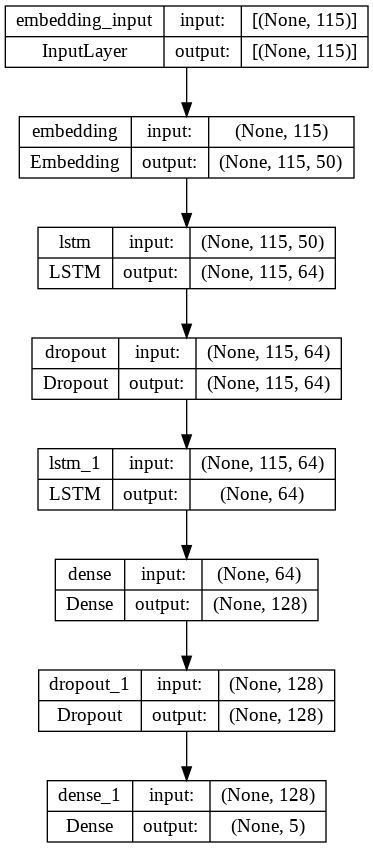

In [37]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [38]:
hist = model.fit(X_train, y_train, epochs=50, validation_split=0.20)

Epoch 1/50
453/453 [==============================] - 89s 185ms/step - loss: 1.0075 - categorical_accuracy: 0.6014 - val_loss: 0.9394 - val_categorical_accuracy: 0.6042
Epoch 2/50
453/453 [==============================] - 72s 159ms/step - loss: 0.8705 - categorical_accuracy: 0.6351 - val_loss: 0.9568 - val_categorical_accuracy: 0.6059
Epoch 3/50
453/453 [==============================] - 72s 159ms/step - loss: 0.8223 - categorical_accuracy: 0.6528 - val_loss: 0.9054 - val_categorical_accuracy: 0.6089
Epoch 4/50
453/453 [==============================] - 70s 154ms/step - loss: 0.7633 - categorical_accuracy: 0.6749 - val_loss: 0.9155 - val_categorical_accuracy: 0.6177
Epoch 5/50
453/453 [==============================] - 71s 158ms/step - loss: 0.7274 - categorical_accuracy: 0.6889 - val_loss: 0.9176 - val_categorical_accuracy: 0.6155
Epoch 6/50
453/453 [==============================] - 70s 156ms/step - loss: 0.6934 - categorical_accuracy: 0.7049 - val_loss: 1.0027 - val_categorical_acc

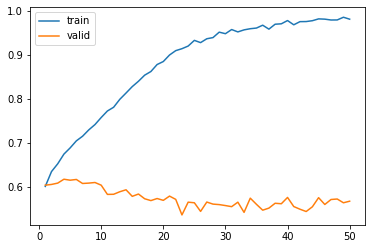

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['categorical_accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['categorical_accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_categorical_accuracy'], label='valid')
plt.show()

In [40]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 5s 36ms/step - loss: 3.6582 - categorical_accuracy: 0.5670


[3.658226728439331, 0.5670126080513]

# PRETRAINED

In [41]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:26<00:00, 109MB/s]


In [42]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [43]:
model_fasttext = FasttextEmbeddings()
# Mirar cómo sube el uso de RAM en colab!

In [44]:
# Crear la Embedding matrix para la cantidad nb_words seleccionadas
# nos vamos a quedar sólo con los vectores de embeddings para las palabras
# que definimos como vocabulario

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word_index o bien elegir otra librería para preprocesamiento
# ¡ver clase 2! ;)
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [45]:
# Definimos el modelo

model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 115, 300)          600000    
                                                                 
 lstm_2 (LSTM)               (None, 115, 64)           93440     
                                                                 
 dropout_2 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                

In [47]:
hist2 = model2.fit(X_train, y_train, epochs=20, validation_split=0.20)

Epoch 1/20
453/453 [==============================] - 98s 216ms/step - loss: 1.1721 - categorical_accuracy: 0.5579 - val_loss: 1.1669 - val_categorical_accuracy: 0.5407
Epoch 2/20
453/453 [==============================] - 93s 206ms/step - loss: 1.1445 - categorical_accuracy: 0.5599 - val_loss: 1.1662 - val_categorical_accuracy: 0.5415
Epoch 3/20
453/453 [==============================] - 96s 212ms/step - loss: 1.1266 - categorical_accuracy: 0.5638 - val_loss: 1.1376 - val_categorical_accuracy: 0.5471
Epoch 4/20
453/453 [==============================] - 94s 207ms/step - loss: 1.1077 - categorical_accuracy: 0.5666 - val_loss: 1.1327 - val_categorical_accuracy: 0.5484
Epoch 5/20
453/453 [==============================] - 93s 206ms/step - loss: 1.0883 - categorical_accuracy: 0.5723 - val_loss: 1.1253 - val_categorical_accuracy: 0.5479
Epoch 6/20
453/453 [==============================] - 101s 223ms/step - loss: 1.0646 - categorical_accuracy: 0.5780 - val_loss: 1.1057 - val_categorical_ac

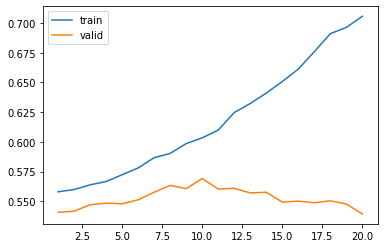

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['categorical_accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['categorical_accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_categorical_accuracy'], label='valid')
plt.show()

In [49]:
model2.evaluate(X_test, y_test)

142/142 [==============================] - 10s 69ms/step - loss: 1.3267 - categorical_accuracy: 0.5323


[1.3266562223434448, 0.5323470830917358]

# CONCLUSIÓN

El objetivo del desafío es alcanzar un accuracy en validación entre 0,50 y 0,70.

Se detectó que el dataset no estaba balanceado, sino que era muchas más las reseñas con 4 y 5 estrellas. Entre estas dos clasificaciones se abarcó el 70% del dataset. La cantidad de estrellas decrece conforme son menores las puntuaciones. Como se detectó un dataset desbalanceado, se lo equilibró obteniendo la misma cantidad de reseñas de 5 estrellas hasta 1.

Se entrenó un modelo de red neuronal RNN LSTM, probando varios parámetros de neuronas. En pocas épocas se alcanzó un overfitting, en donde en entrenamiento se logró un accuracy del 90% pero en validación hasta 30%, cosa que no era suficiente para el objetivo del desafío.

Se probó también con embeddings preentrenados y se logró una performance parecida, con accuravy de 30%.

Finalmente, se probó con todo el dataset completo, sin balancear, y se alcanzó un accuracy del 60% en el modelo de embeddings sin preentrenamiento.

Lo que se sospecha que está ocurriendo es que con 4 y 5 puntos de rating se cubre el 70% del dataset, porque esta fuertemente desbalanceado. ENtonces, si el modelo predice sólo ratings de 4 y 5 puntos estaría logrando un accuracy alto. El problema es que estaría subestimando la realidad porque es un modelo sesgado. La otra métrica a atender es el recall, que es sencillo de comprender para problemas binarios, pero para multi clase es poco común.